# Through Earnings Mean vs. Mean Delta Event Study

In this notebook we explore the relationship between the median and mean Estimize EPS delta (just prior to the earnings announcement) and the cumulative residual returns starting from the close before the earnings announcement and in the days following.

**Conclusions:**

* There is a small but positive cumulative residual return when the EPS delta is positive and vice versa

## Data and Methodology

**Datasources:**

* Estimize EPS Consensuses (consensus.csv)
* Estimize EPS Estimates (estimates.csv)
* Asset historical prices (Zipline.io/Quandl prices dataset)
* SPY historical prices (Yahoo Finance)

Our first step is to generate the Wall Street and Estimize Weighted EPS deltas for each release:

$$EPSDelta = \frac{EPS_{median} - EPS_{mean}}{STDEV_{estimize} + 0.01}$$

Where $STDEV_{estimize}$ is the standard deviation of the release's estimize consensus.

After calculating the EPS deltas for all reported releases, we group them by quantile, with 1 being the lowest and 5 being the highest. This set of data represents the events we will plug into the event study.

The next step is to get the residual returns for each stock following an event. We calculate the residual returns using the CAPM with S&P500 index as the market portfolio:

$$E(R_{i,t})=b_0 + b_1 \cdot E(R_{M,t})$$

,

$$ResidualReturn_{i,t}=R_{i,t} - E(R_{i,t})$$

Finally, we take the cumulative residual returns over the days in the event study grouped by the EPS delta quantile.


In [1]:
# Imports

from datetime import timedelta
from IPython.display import display, HTML, Markdown
import logging.config
import math
import os
import sys

from injector import Injector
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import stats

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from estimize.logging import configure_logging
from estimize.di.default_module import DefaultModule
from estimize.services import (
    AssetService, AssetInfoService, CalendarService, EstimatesService, 
    EstimizeConsensusService, EventStudyService, MarketCapService, ReleasesService
)
from estimize.pandas import dfutils

configure_logging('ERROR')

injector = Injector([DefaultModule])
asset_service = injector.get(AssetService)
calendar_service = injector.get(CalendarService)
estimates_service = injector.get(EstimatesService)
releases_service = injector.get(ReleasesService)
estimize_consensus_service = injector.get(EstimizeConsensusService)


In [2]:
DEFAULT_START_DATE = '2012-01-01'
DEFAULT_END_DATE = '2018-01-01'

def plot_results(df):
    """
    Plots cumulative residual returns based on decile.
    
    Parameters
    ----------
    df : pd.DataFrame
    """
    df = df.reset_index()
    df.set_index('event_time', inplace=True)
    
    plt.figure(figsize=(16, 10))
    
    quantiles = list(df['quantile'].astype('int').unique())
    quantiles.reverse()
    
    cm = plt.get_cmap('jet_r') 
    c_norm  = colors.Normalize(vmin=quantiles[-1], vmax=quantiles[0])
    scalar_map = cmx.ScalarMappable(norm=c_norm, cmap=cm)
    
    for quantile in quantiles:
        if quantile == quantiles[0] or quantile == quantiles[-1]:
            linewidth = 2.0
        else:
            linewidth = 1.0
            
        color = scalar_map.to_rgba(quantile)
            
        ddf = df.loc[df['quantile'] == quantile, 'cumulative_residual_return']
        ddf -= ddf.iloc[0]
        ddf *= 100.0
        ddf.plot(xticks=range(0, 21), label=quantile, linewidth=linewidth, color=color)
        
    plt.plot([0 for _ in range(0, 21)], 'r--')
    
    plt.ylabel("% Cumulative Residual Return")
    plt.xlabel("Event Time")
    plt.gca().grid(True)
    plt.legend(title='Quantile', loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

def display_table(df):
    df = df.reset_index()

    df = pd.pivot_table(df, values='cumulative_residual_return', index='quantile', columns=['event_time'])
    df *= 100
    df = df.subtract(df[0], axis='index')
    df = df[[1, 2, 3, 4, 5, 10, 15, 20]]
    df = df.applymap("{0:.2f}%".format)
    display(df)

def display_results(es, title=None):
    df, events = es
    num_events = df.loc[df.index.get_level_values('event_time') == 0, 'count'].sum()
    
    if title is not None:
        display(Markdown('### {}'.format(title)))
        
    print('Num Events: {:,}'.format(num_events))
    
    plot_results(df)
    display_table(df)

def filter(df, column, value):
    return df[dfutils.column_values(df, column) == value]

def shift_date_fn(days):
    if days > 0:
        index = -1
    else:
        index = 0
    
    def shift_date(date):
        if days != 0:
            return calendar_service.get_n_trading_days_from(days, date)[index]
        else:
            return date
    
    return shift_date  

def fix_index(df):
    def fix_row_index(row):
        index = row[0]
        cols = row[1]
        date = index[0]
        asset = index[1]

        if cols['bmo']:
            date = date - timedelta(days=1)

        date = calendar_service.get_valid_trading_end_date(date)

        return date, asset

    df.index = pd.MultiIndex.from_tuples(list(map(fix_row_index, df.iterrows())))
    df.index.names = ['as_of_date', 'asset']
    
def get_median_eps(start_date, end_date):
    rdf = releases_service.get_releases(start_date, end_date)
    rdf.reset_index(inplace=True)
    rdf.set_index('release_id', inplace=True)
    
    df = estimates_service.get_estimates()
    df.reset_index(inplace=True)
    df = df[df['flagged'] == False]
    df.set_index('release_id', inplace=True)
    
    df = df.join(rdf, how='inner')
    df.reset_index(inplace=True)
    
    dfg = df.groupby(['asset', 'fiscal_year', 'fiscal_quarter'])
    df = dfg[['eps']].skew()
    df.rename(columns={'eps': 'estimize.eps.skew'}, inplace=True)
    
    return df

def get_eps_deltas(start_date, end_date):
    mdf = get_median_eps(start_date, end_date)
    
    df = estimize_consensus_service.get_final_consensuses(start_date, end_date)
    df.reset_index(inplace=True)
    df.set_index(['asset', 'fiscal_year', 'fiscal_quarter'], inplace=True)
    
    df = df.join(mdf, how='inner')
    df.reset_index(inplace=True)
    df.set_index(['as_of_date', 'asset'], inplace=True)
    
    df['eps_delta'] = df['estimize.eps.skew']
    df = df[['bmo', 'eps_delta']].copy()
    df.dropna(inplace=True)
    fix_index(df)
    df.drop(['bmo'], axis=1, inplace=True)
    
    return df

def get_events(start_date, end_date):
    df = get_eps_deltas(start_date, end_date)
    
    # Filter on universe
    udf = asset_service.get_universe(start_date, end_date)
    df = df.join(udf, how='inner')
    
    # Add quantile
    df['quantile'] = pd.qcut(df['eps_delta'].values, 5, labels=False) + 1
    df.drop(['eps_delta'], axis=1, inplace=True)
    
    return df

def run_event_study(start_date, end_date, join_fn=None):
    event_study_service = injector.get(EventStudyService)
    events = get_events(start_date, end_date)
    
    if join_fn is not None:
        events = join_fn(start_date, end_date, events)
    
    df = event_study_service.run_event_study(
        events=events,
        on='close',
        days_before=0,
        days_after=20
    )
    
    return (df, events)

def join_sectors(start_date, end_date, events):
    asset_info_service = injector.get(AssetInfoService)
    df = asset_info_service.get_asset_info()['sector']

    events.reset_index(inplace=True)
    events.set_index('asset', inplace=True)
    events = events.join(df, how='inner')

    events.reset_index(inplace=True)
    events.set_index(['as_of_date', 'asset'], inplace=True)

    return events

def join_market_caps(start_date, end_date, events):
    market_cap_service = injector.get(MarketCapService)
    assets = dfutils.unique_assets(events)
    df = market_cap_service.get_market_caps(start_date, end_date, assets)['market_cap_type']
    df.rename({'market_cap_type': 'market_cap'}, inplace=True)

    events = events.join(df, how='inner')

    return events


## EPS Deltas

-7.620994535338533
0.26725252987178094
10.953096260402031


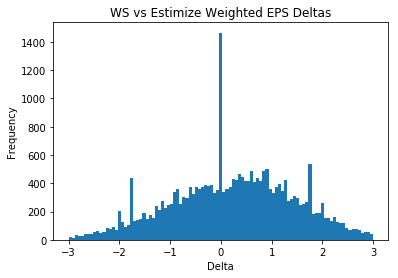

In [3]:
edf = get_eps_deltas(DEFAULT_START_DATE, DEFAULT_END_DATE)['eps_delta']
print(edf.min())
print(edf.mean())
print(edf.max())

bins = np.linspace(-3, 3, 100)
plt.hist(edf, bins)
plt.title("WS vs Estimize Weighted EPS Deltas")
plt.xlabel("Delta")
plt.ylabel("Frequency")
plt.show()


In [4]:
# Run all-time event study

es_alltime = run_event_study(DEFAULT_START_DATE, DEFAULT_END_DATE)


### All Stocks (All-time)

Num Events: 23,734


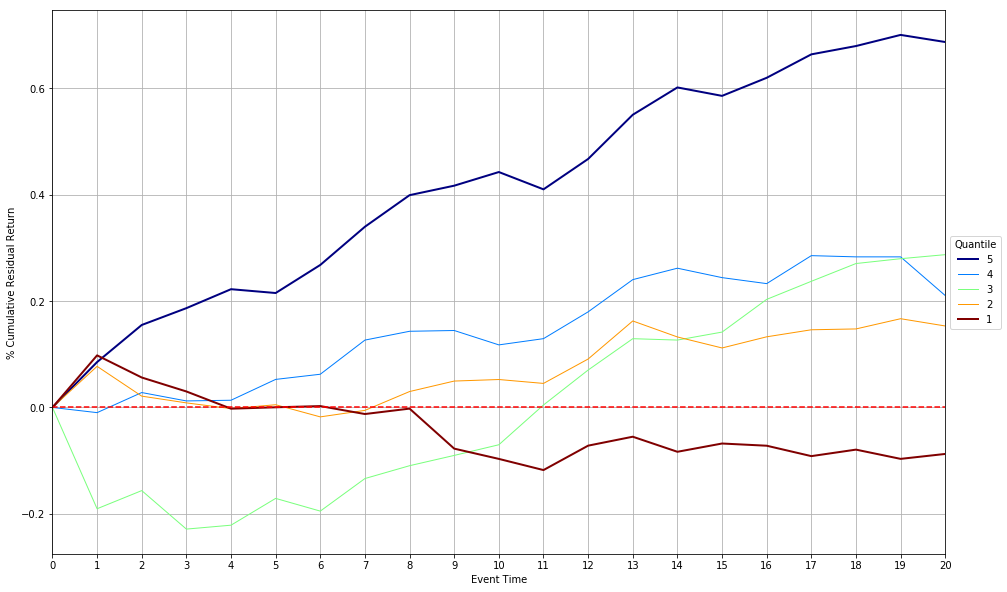

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1.0,0.10%,0.06%,0.03%,-0.00%,0.00%,-0.10%,-0.07%,-0.09%
2.0,0.08%,0.02%,0.01%,-0.00%,0.01%,0.05%,0.11%,0.15%
3.0,-0.19%,-0.16%,-0.23%,-0.22%,-0.17%,-0.07%,0.14%,0.29%
4.0,-0.01%,0.03%,0.01%,0.01%,0.05%,0.12%,0.24%,0.21%
5.0,0.09%,0.16%,0.19%,0.22%,0.22%,0.44%,0.59%,0.69%


In [5]:
display_results(es_alltime, 'All Stocks (All-time)')

In [6]:
# Run 2017 event study

start_date = '2017-01-01'
end_date = '2018-01-01'

es2017 = run_event_study(start_date, end_date)

### All Stocks (2017)

Num Events: 6,086


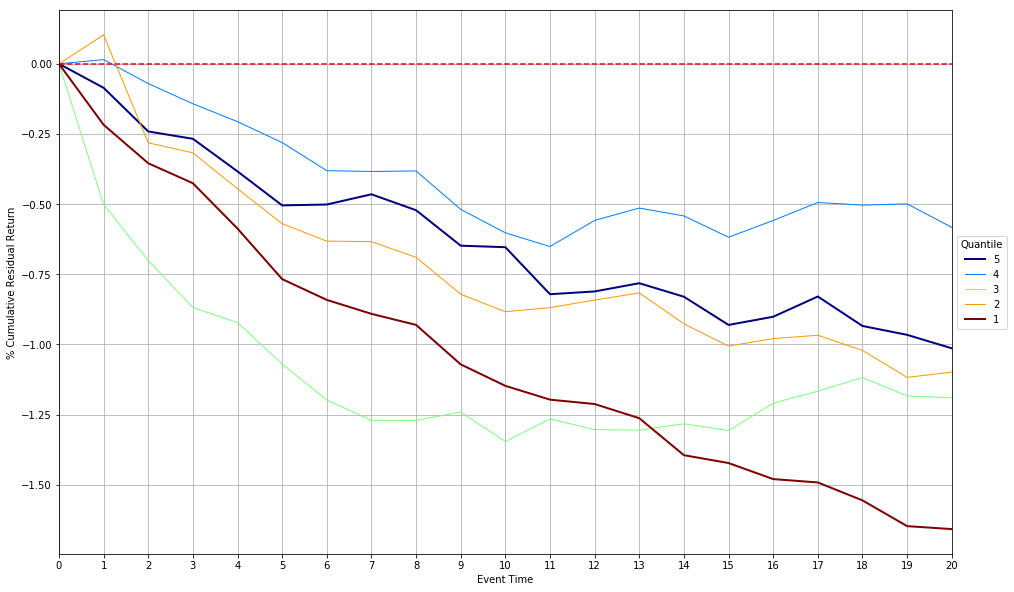

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1.0,-0.22%,-0.35%,-0.43%,-0.59%,-0.77%,-1.15%,-1.42%,-1.66%
2.0,0.10%,-0.28%,-0.32%,-0.44%,-0.57%,-0.88%,-1.01%,-1.10%
3.0,-0.50%,-0.70%,-0.87%,-0.92%,-1.07%,-1.35%,-1.31%,-1.19%
4.0,0.02%,-0.07%,-0.14%,-0.21%,-0.28%,-0.60%,-0.62%,-0.58%
5.0,-0.09%,-0.24%,-0.27%,-0.38%,-0.50%,-0.65%,-0.93%,-1.01%


In [7]:
display_results(es2017, 'All Stocks (2017)')

In [8]:
# Run 2016 event study

start_date = '2016-01-01'
end_date = '2017-01-01'

es2016 = run_event_study(start_date, end_date)

### All Stocks (2016)

Num Events: 5,881


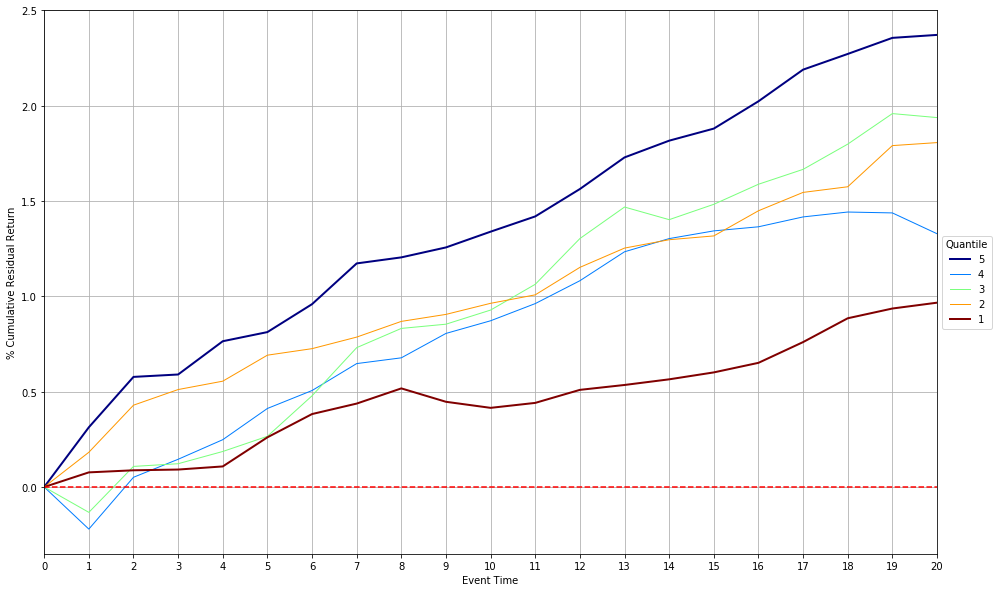

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1.0,0.08%,0.09%,0.09%,0.11%,0.26%,0.42%,0.60%,0.97%
2.0,0.18%,0.43%,0.51%,0.56%,0.69%,0.96%,1.32%,1.81%
3.0,-0.13%,0.11%,0.12%,0.19%,0.27%,0.93%,1.48%,1.94%
4.0,-0.22%,0.05%,0.15%,0.25%,0.41%,0.87%,1.34%,1.33%
5.0,0.31%,0.58%,0.59%,0.76%,0.81%,1.34%,1.88%,2.37%


In [9]:
display_results(es2016, 'All Stocks (2016)')

In [10]:
# Run 2015 event study

start_date = '2015-01-01'
end_date = '2016-01-01'

es2015 = run_event_study(start_date, end_date)

### All Stocks (2015)

Num Events: 4,764


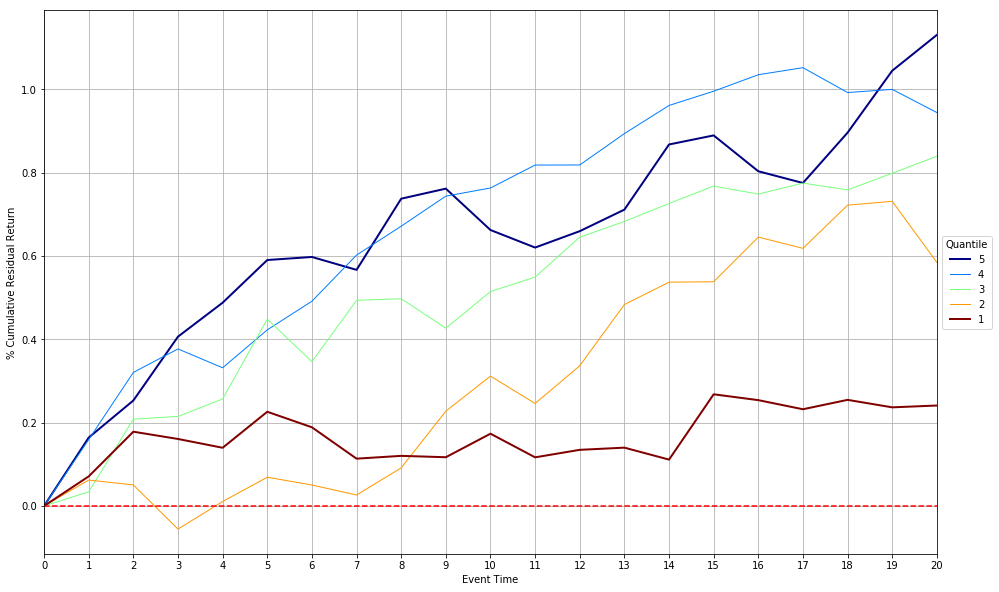

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1.0,0.07%,0.18%,0.16%,0.14%,0.23%,0.17%,0.27%,0.24%
2.0,0.06%,0.05%,-0.06%,0.01%,0.07%,0.31%,0.54%,0.58%
3.0,0.03%,0.21%,0.21%,0.26%,0.45%,0.51%,0.77%,0.84%
4.0,0.16%,0.32%,0.38%,0.33%,0.42%,0.76%,1.00%,0.94%
5.0,0.16%,0.25%,0.41%,0.49%,0.59%,0.66%,0.89%,1.13%


In [11]:
display_results(es2015, 'All Stocks (2015)')

In [12]:
# Run 2014 event study

start_date = '2014-01-01'
end_date = '2015-01-01'

es2014 = run_event_study(start_date, end_date)

### All Stocks (2014)

Num Events: 3,379


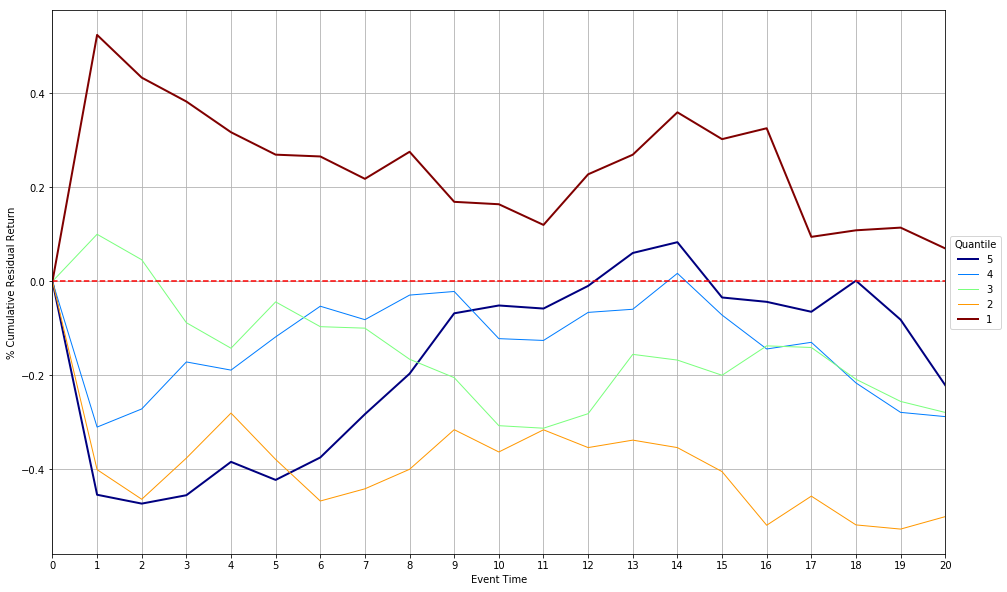

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1.0,0.52%,0.43%,0.38%,0.32%,0.27%,0.16%,0.30%,0.07%
2.0,-0.40%,-0.46%,-0.38%,-0.28%,-0.38%,-0.36%,-0.40%,-0.50%
3.0,0.10%,0.05%,-0.09%,-0.14%,-0.04%,-0.31%,-0.20%,-0.28%
4.0,-0.31%,-0.27%,-0.17%,-0.19%,-0.12%,-0.12%,-0.07%,-0.29%
5.0,-0.45%,-0.47%,-0.46%,-0.38%,-0.42%,-0.05%,-0.03%,-0.22%


In [13]:
display_results(es2014, 'All Stocks (2014)')

In [14]:
# Run 2013 event study

start_date = '2013-01-01'
end_date = '2014-01-01'

es2013 = run_event_study(start_date, end_date)

### All Stocks (2013)

Num Events: 2,580


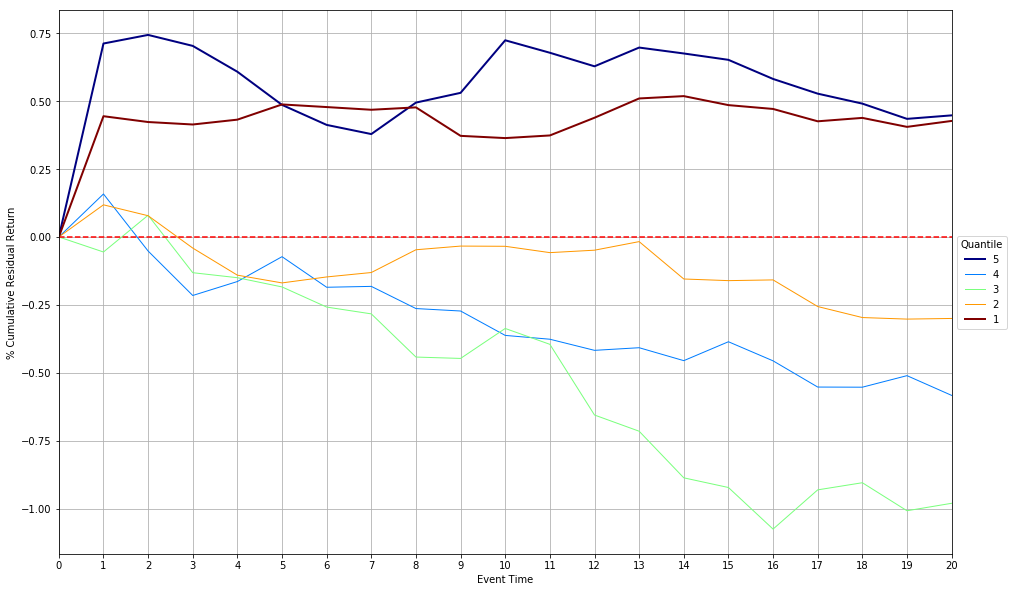

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1.0,0.44%,0.42%,0.41%,0.43%,0.49%,0.36%,0.49%,0.43%
2.0,0.12%,0.08%,-0.04%,-0.14%,-0.17%,-0.03%,-0.16%,-0.30%
3.0,-0.06%,0.08%,-0.13%,-0.15%,-0.18%,-0.34%,-0.92%,-0.98%
4.0,0.16%,-0.05%,-0.22%,-0.16%,-0.07%,-0.36%,-0.39%,-0.58%
5.0,0.71%,0.74%,0.70%,0.61%,0.49%,0.72%,0.65%,0.45%


In [15]:
display_results(es2013, 'All Stocks (2013)')

In [16]:
# Run 2012 event study

start_date = '2012-01-01'
end_date = '2013-01-01'

es2012 = run_event_study(start_date, end_date)

### All Stocks (2012)

Num Events: 992


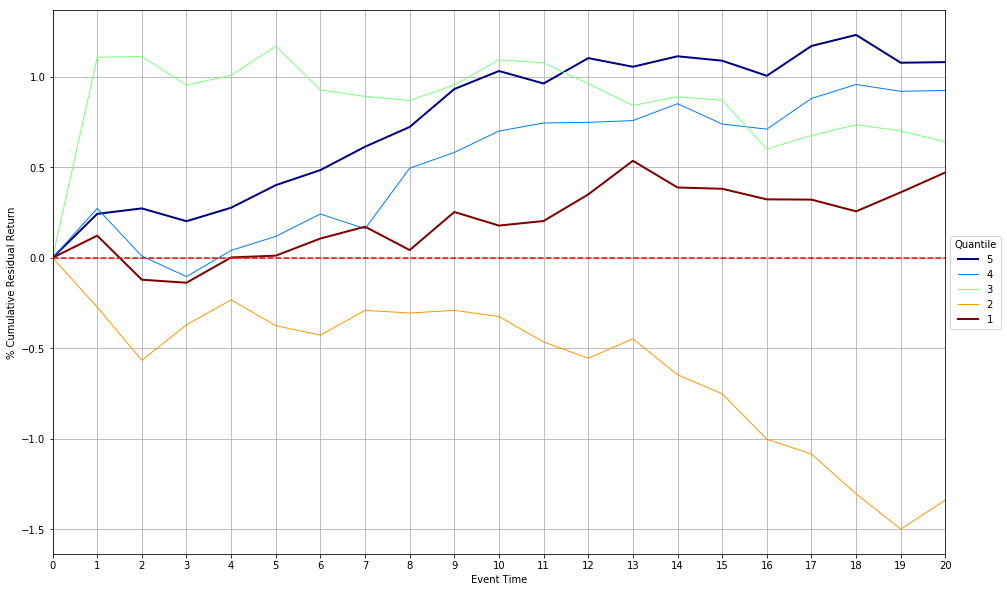

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1.0,0.12%,-0.12%,-0.14%,0.00%,0.01%,0.18%,0.38%,0.47%
2.0,-0.27%,-0.57%,-0.37%,-0.23%,-0.38%,-0.33%,-0.75%,-1.34%
3.0,1.11%,1.11%,0.95%,1.01%,1.17%,1.09%,0.87%,0.64%
4.0,0.27%,0.01%,-0.10%,0.04%,0.12%,0.70%,0.74%,0.92%
5.0,0.24%,0.27%,0.20%,0.28%,0.40%,1.03%,1.09%,1.08%


In [17]:
display_results(es2012, 'All Stocks (2012)')

## Sector Analysis

In [18]:
es_sectors = run_event_study(DEFAULT_START_DATE, DEFAULT_END_DATE, join_fn=join_sectors)


### Consumer Discretionary (All-Time)

Num Events: 4,933


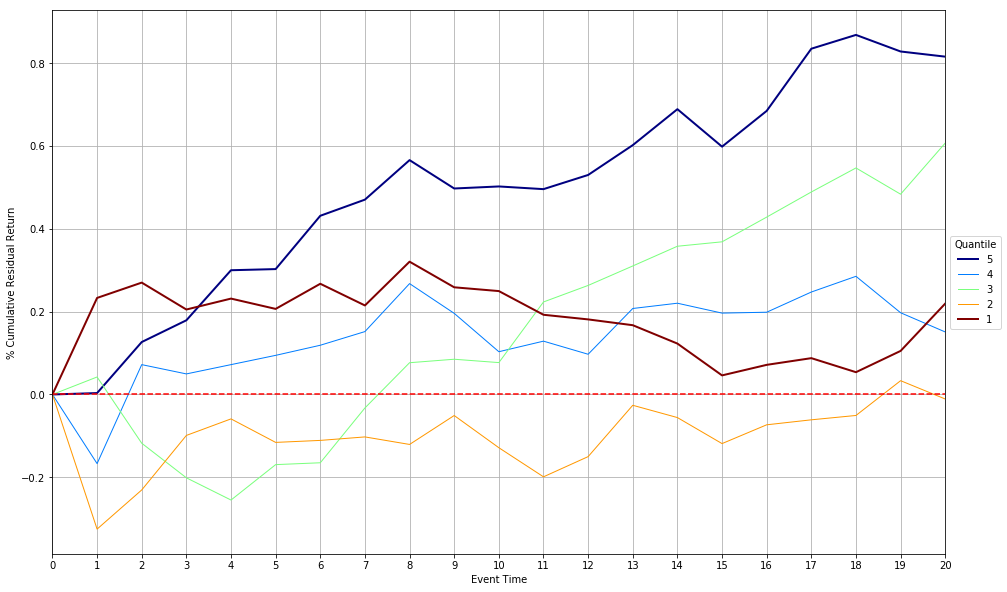

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,0.23%,0.27%,0.21%,0.23%,0.21%,0.25%,0.05%,0.22%
2,-0.33%,-0.23%,-0.10%,-0.06%,-0.12%,-0.13%,-0.12%,-0.01%
3,0.04%,-0.12%,-0.20%,-0.25%,-0.17%,0.08%,0.37%,0.61%
4,-0.17%,0.07%,0.05%,0.07%,0.09%,0.10%,0.20%,0.15%
5,0.00%,0.13%,0.18%,0.30%,0.30%,0.50%,0.60%,0.82%


### Consumer Staples (All-Time)

Num Events: 1,388


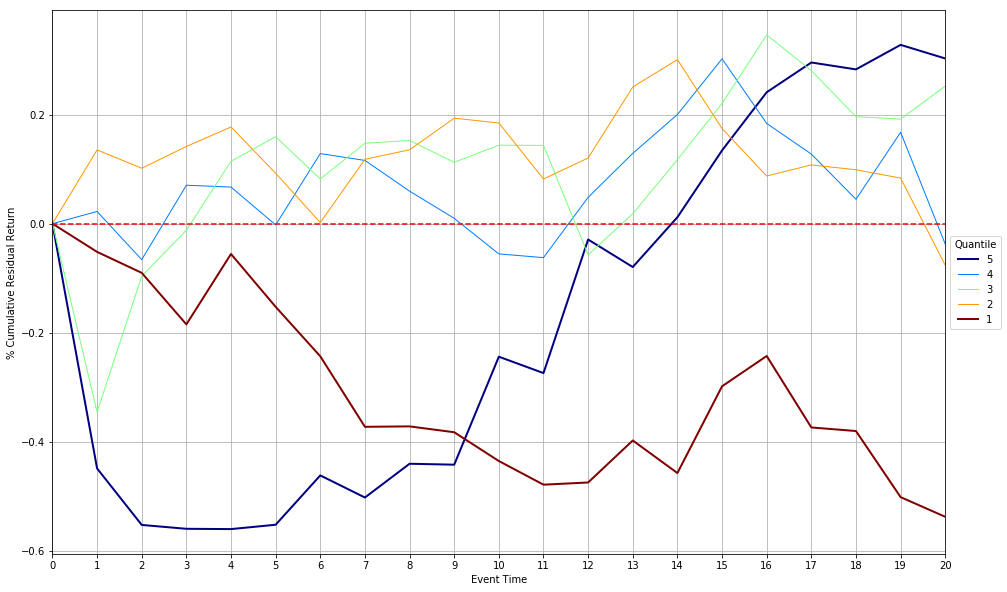

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.05%,-0.09%,-0.18%,-0.06%,-0.15%,-0.44%,-0.30%,-0.54%
2,0.14%,0.10%,0.14%,0.18%,0.09%,0.18%,0.17%,-0.08%
3,-0.35%,-0.10%,-0.01%,0.11%,0.16%,0.14%,0.22%,0.25%
4,0.02%,-0.07%,0.07%,0.07%,-0.00%,-0.06%,0.30%,-0.04%
5,-0.45%,-0.55%,-0.56%,-0.56%,-0.55%,-0.24%,0.13%,0.30%


### Energy (All-Time)

Num Events: 1,286


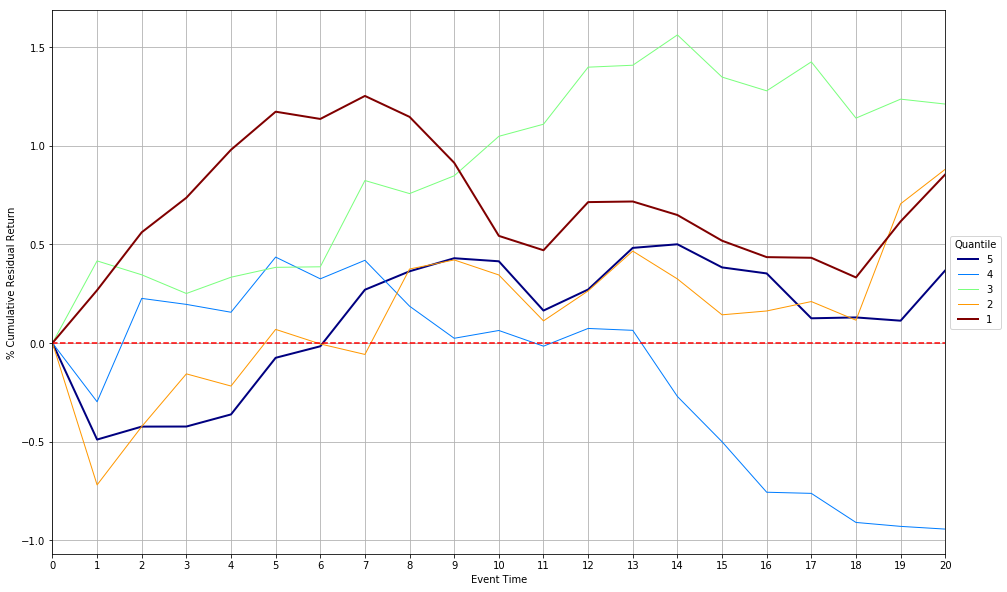

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,0.27%,0.56%,0.74%,0.98%,1.17%,0.54%,0.52%,0.85%
2,-0.72%,-0.42%,-0.16%,-0.22%,0.07%,0.34%,0.14%,0.88%
3,0.42%,0.35%,0.25%,0.33%,0.38%,1.05%,1.35%,1.21%
4,-0.30%,0.23%,0.20%,0.16%,0.44%,0.06%,-0.50%,-0.94%
5,-0.49%,-0.42%,-0.42%,-0.36%,-0.08%,0.41%,0.38%,0.37%


### Financials (All-Time)

Num Events: 1,522


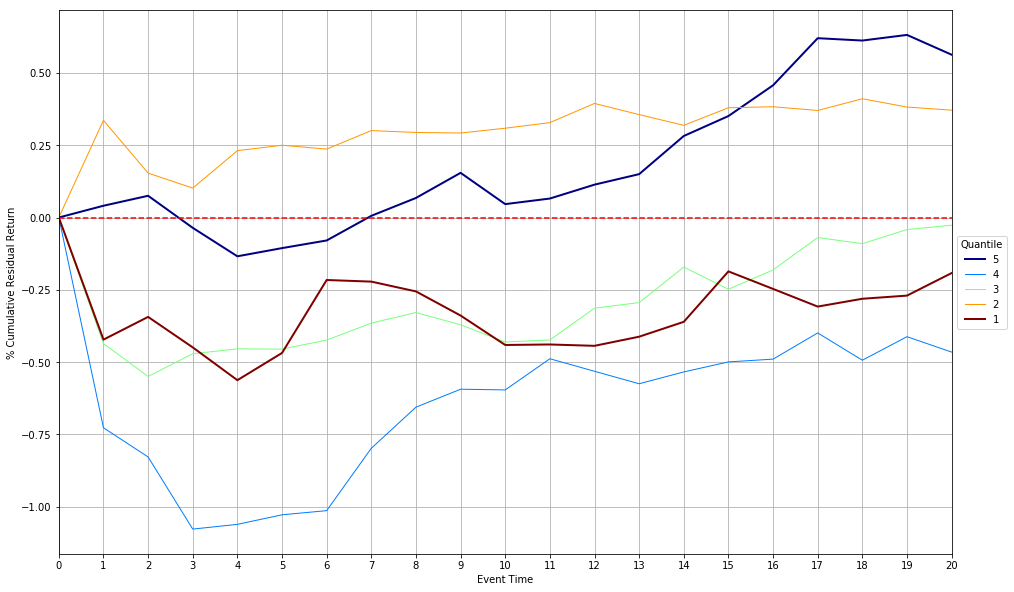

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.42%,-0.34%,-0.45%,-0.56%,-0.47%,-0.44%,-0.19%,-0.19%
2,0.34%,0.15%,0.10%,0.23%,0.25%,0.31%,0.38%,0.37%
3,-0.44%,-0.55%,-0.47%,-0.45%,-0.46%,-0.43%,-0.25%,-0.03%
4,-0.73%,-0.83%,-1.08%,-1.06%,-1.03%,-0.60%,-0.50%,-0.47%
5,0.04%,0.08%,-0.04%,-0.13%,-0.11%,0.05%,0.35%,0.56%


### Health Care (All-Time)

Num Events: 2,974


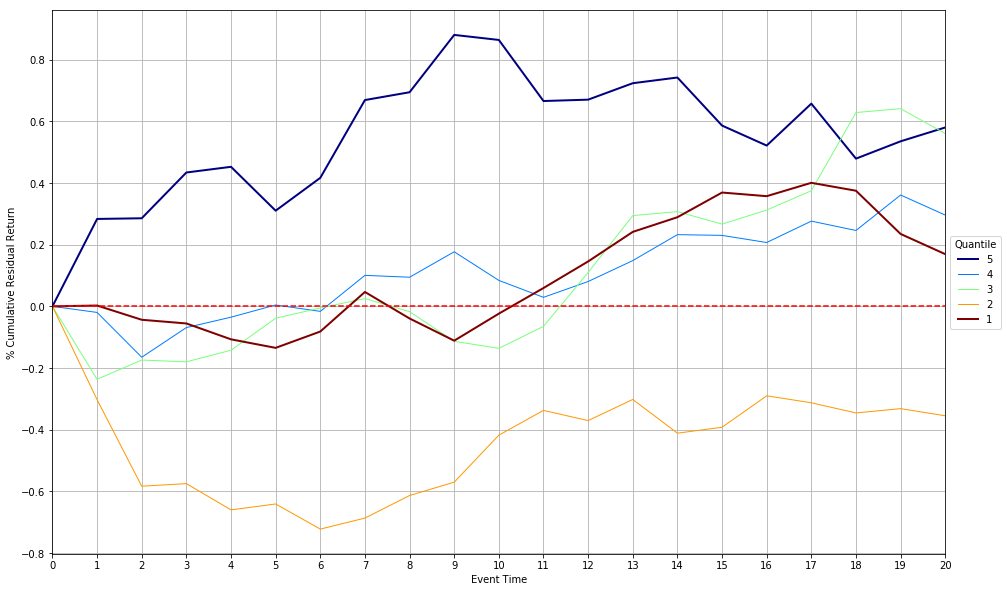

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,0.00%,-0.04%,-0.06%,-0.11%,-0.13%,-0.02%,0.37%,0.17%
2,-0.30%,-0.58%,-0.57%,-0.66%,-0.64%,-0.42%,-0.39%,-0.35%
3,-0.24%,-0.17%,-0.18%,-0.14%,-0.04%,-0.14%,0.27%,0.56%
4,-0.02%,-0.17%,-0.07%,-0.04%,0.00%,0.08%,0.23%,0.30%
5,0.28%,0.29%,0.43%,0.45%,0.31%,0.86%,0.59%,0.58%


### Industrials (All-Time)

Num Events: 4,007


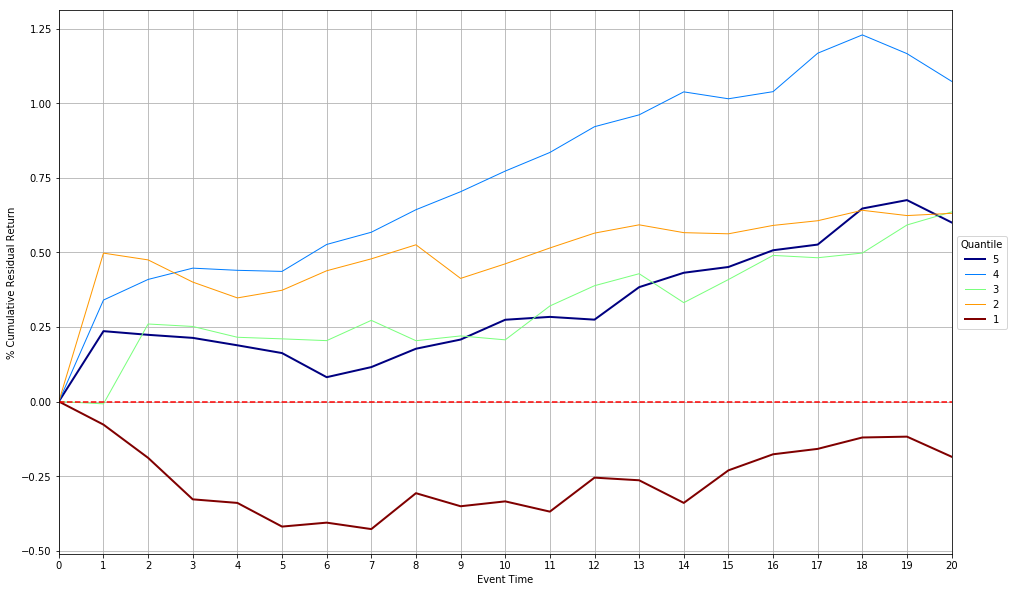

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.08%,-0.19%,-0.33%,-0.34%,-0.42%,-0.34%,-0.23%,-0.19%
2,0.50%,0.48%,0.40%,0.35%,0.37%,0.46%,0.56%,0.63%
3,-0.01%,0.26%,0.25%,0.22%,0.21%,0.21%,0.41%,0.64%
4,0.34%,0.41%,0.45%,0.44%,0.44%,0.77%,1.02%,1.07%
5,0.24%,0.22%,0.21%,0.19%,0.16%,0.27%,0.45%,0.60%


### Information Technology (All-Time)

Num Events: 5,340


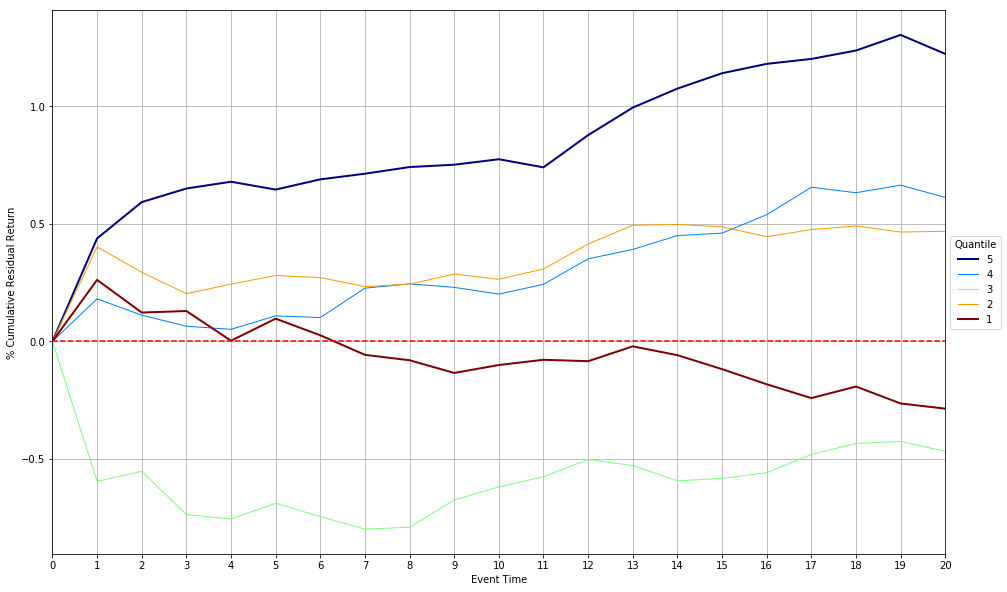

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,0.26%,0.12%,0.13%,0.00%,0.10%,-0.10%,-0.12%,-0.29%
2,0.40%,0.29%,0.20%,0.24%,0.28%,0.26%,0.49%,0.47%
3,-0.60%,-0.55%,-0.74%,-0.76%,-0.69%,-0.62%,-0.58%,-0.47%
4,0.18%,0.11%,0.06%,0.05%,0.11%,0.20%,0.46%,0.61%
5,0.44%,0.59%,0.65%,0.68%,0.65%,0.78%,1.14%,1.22%


### Materials (All-Time)

Num Events: 1,387


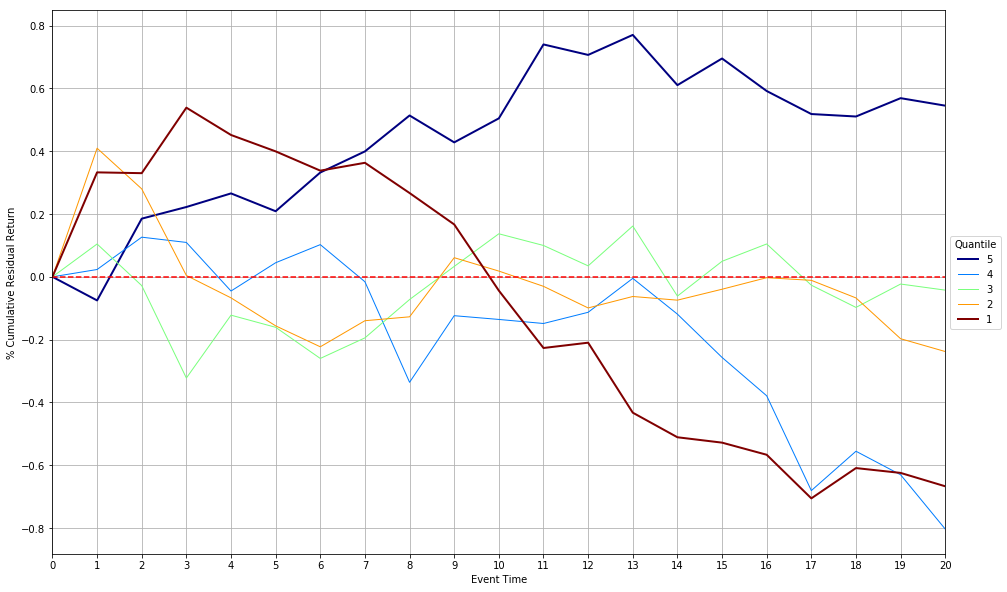

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,0.33%,0.33%,0.54%,0.45%,0.40%,-0.04%,-0.53%,-0.67%
2,0.41%,0.28%,0.00%,-0.07%,-0.16%,0.02%,-0.04%,-0.24%
3,0.10%,-0.03%,-0.32%,-0.12%,-0.16%,0.14%,0.05%,-0.04%
4,0.02%,0.13%,0.11%,-0.05%,0.04%,-0.14%,-0.26%,-0.80%
5,-0.08%,0.19%,0.22%,0.27%,0.21%,0.50%,0.70%,0.54%


### Telecommunication Services (All-Time)

Num Events: 272


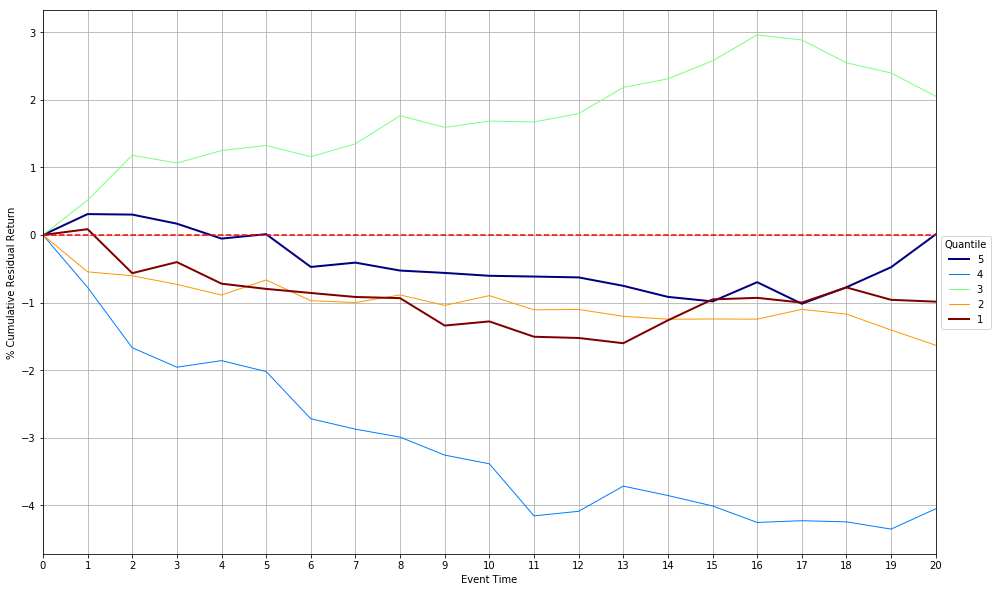

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,0.09%,-0.56%,-0.40%,-0.72%,-0.80%,-1.28%,-0.95%,-0.99%
2,-0.55%,-0.60%,-0.73%,-0.89%,-0.67%,-0.90%,-1.24%,-1.63%
3,0.52%,1.18%,1.06%,1.25%,1.32%,1.68%,2.58%,2.05%
4,-0.78%,-1.67%,-1.96%,-1.86%,-2.02%,-3.38%,-4.01%,-4.05%
5,0.31%,0.30%,0.17%,-0.05%,0.01%,-0.60%,-0.98%,0.01%


### Utilities (All-Time)

Num Events: 625


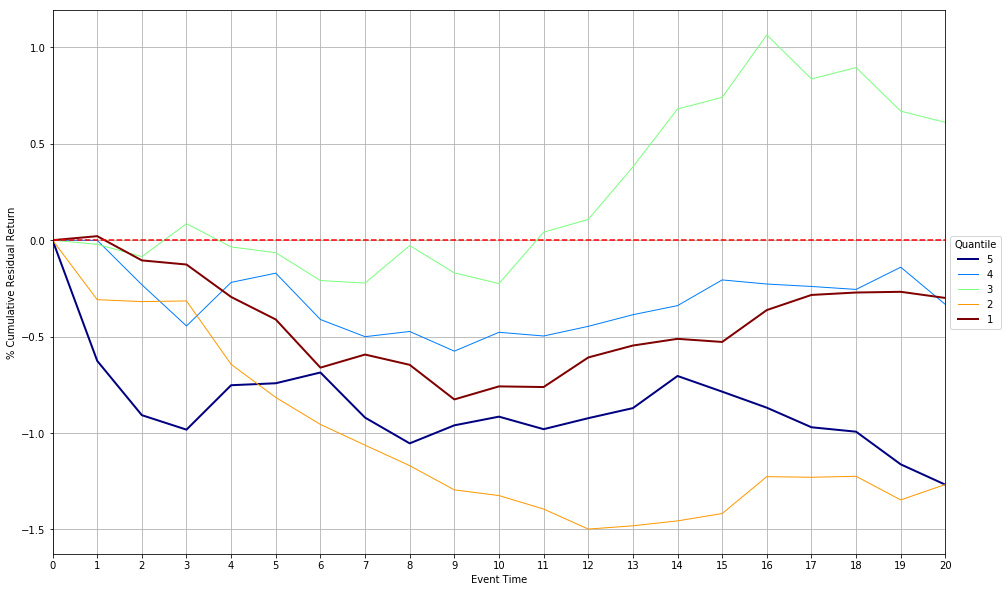

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,0.02%,-0.10%,-0.13%,-0.29%,-0.41%,-0.76%,-0.53%,-0.30%
2,-0.31%,-0.32%,-0.31%,-0.64%,-0.82%,-1.32%,-1.42%,-1.27%
3,-0.02%,-0.09%,0.09%,-0.03%,-0.06%,-0.23%,0.74%,0.61%
4,-0.00%,-0.23%,-0.44%,-0.22%,-0.17%,-0.48%,-0.21%,-0.33%
5,-0.63%,-0.91%,-0.98%,-0.75%,-0.74%,-0.91%,-0.79%,-1.27%


In [19]:
sectors = dfutils.column_values(es_sectors[0], 'sector').unique().tolist()

for sector in sectors:
    sdf = es_sectors[0]
    sdf = filter(sdf, 'sector', sector)
    display_results((sdf, None), '{} (All-Time)'.format(sector))


## Market Cap Analysis

In [20]:
es_market_caps = run_event_study(DEFAULT_START_DATE, DEFAULT_END_DATE, join_fn=join_market_caps)


### Micro Cap (All-Time)

Num Events: 386


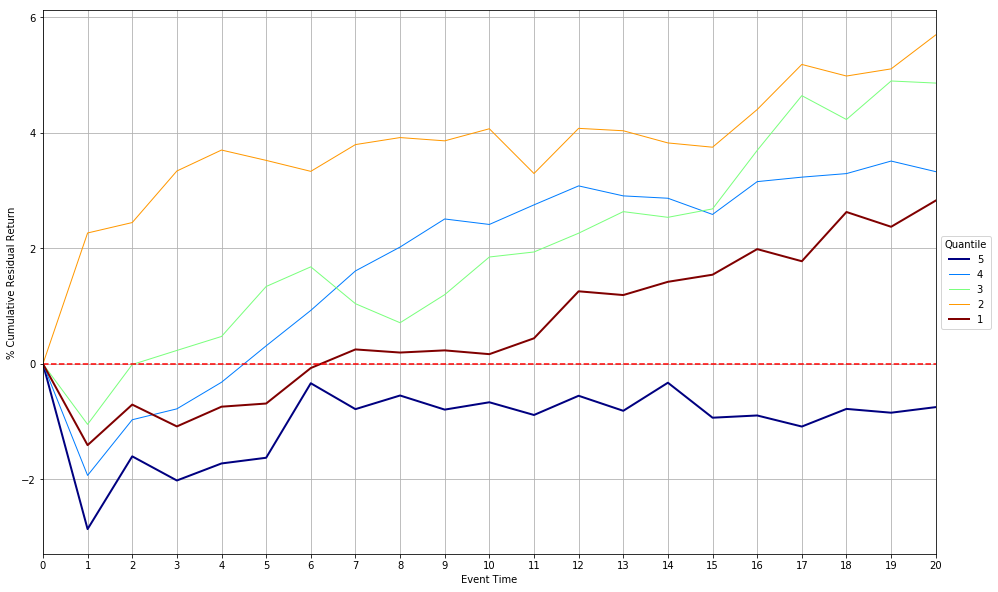

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-1.41%,-0.71%,-1.08%,-0.74%,-0.69%,0.17%,1.54%,2.83%
2,2.27%,2.45%,3.34%,3.70%,3.52%,4.07%,3.75%,5.69%
3,-1.05%,-0.01%,0.23%,0.47%,1.34%,1.85%,2.68%,4.86%
4,-1.93%,-0.97%,-0.78%,-0.32%,0.31%,2.41%,2.59%,3.33%
5,-2.86%,-1.60%,-2.02%,-1.72%,-1.63%,-0.66%,-0.93%,-0.75%


### Small Cap (All-Time)

Num Events: 7,421


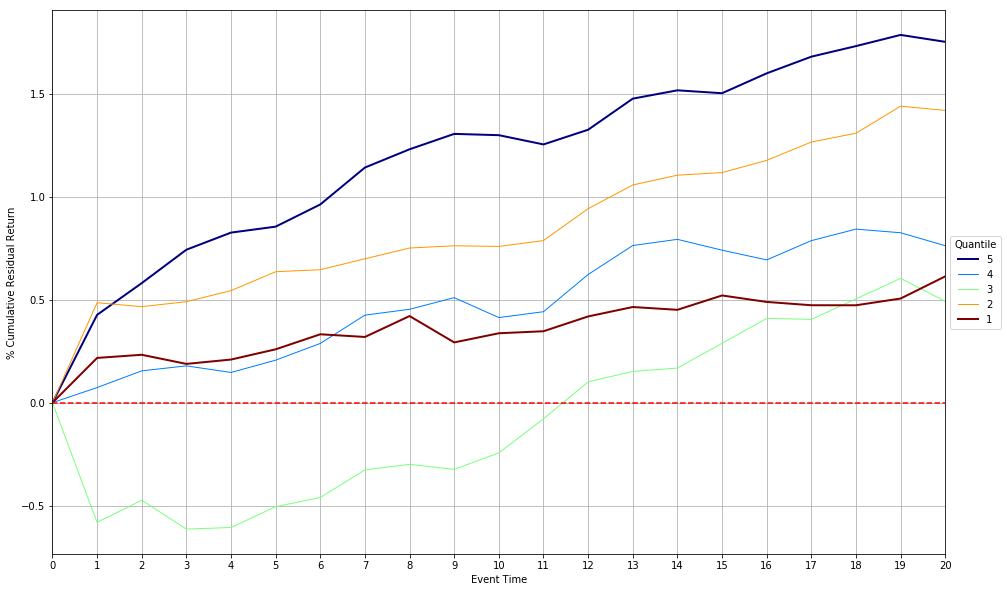

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,0.22%,0.23%,0.19%,0.21%,0.26%,0.34%,0.52%,0.61%
2,0.49%,0.47%,0.49%,0.54%,0.64%,0.76%,1.12%,1.42%
3,-0.58%,-0.47%,-0.61%,-0.61%,-0.51%,-0.24%,0.29%,0.49%
4,0.07%,0.15%,0.18%,0.15%,0.21%,0.41%,0.74%,0.76%
5,0.43%,0.58%,0.74%,0.83%,0.85%,1.30%,1.50%,1.75%


### Mid Cap (All-Time)

Num Events: 8,806


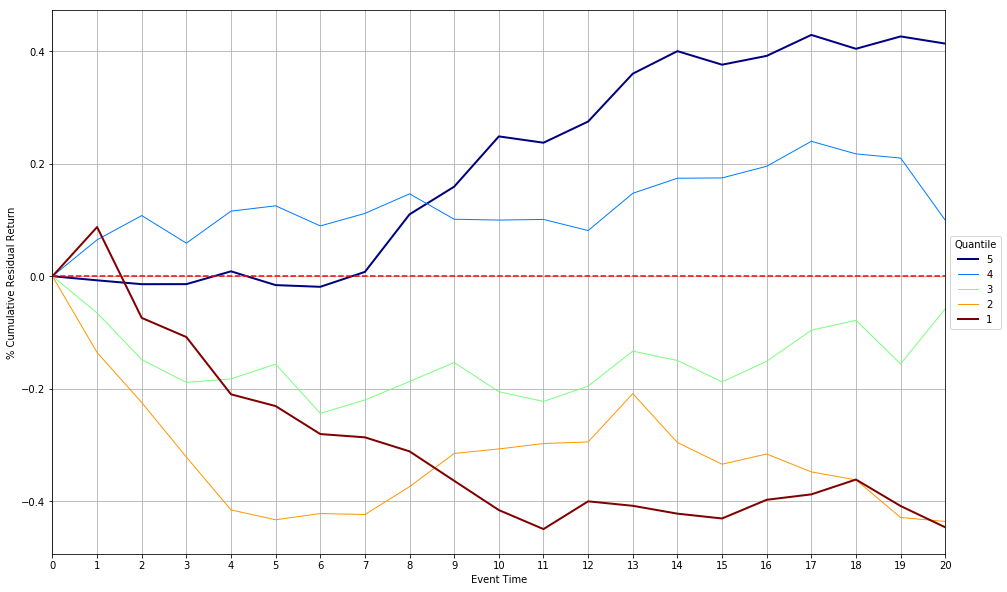

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,0.09%,-0.07%,-0.11%,-0.21%,-0.23%,-0.42%,-0.43%,-0.45%
2,-0.14%,-0.22%,-0.32%,-0.42%,-0.43%,-0.31%,-0.33%,-0.44%
3,-0.07%,-0.15%,-0.19%,-0.18%,-0.16%,-0.21%,-0.19%,-0.06%
4,0.06%,0.11%,0.06%,0.12%,0.13%,0.10%,0.17%,0.10%
5,-0.01%,-0.01%,-0.01%,0.01%,-0.02%,0.25%,0.38%,0.41%


### Large Cap (All-Time)

Num Events: 6,610


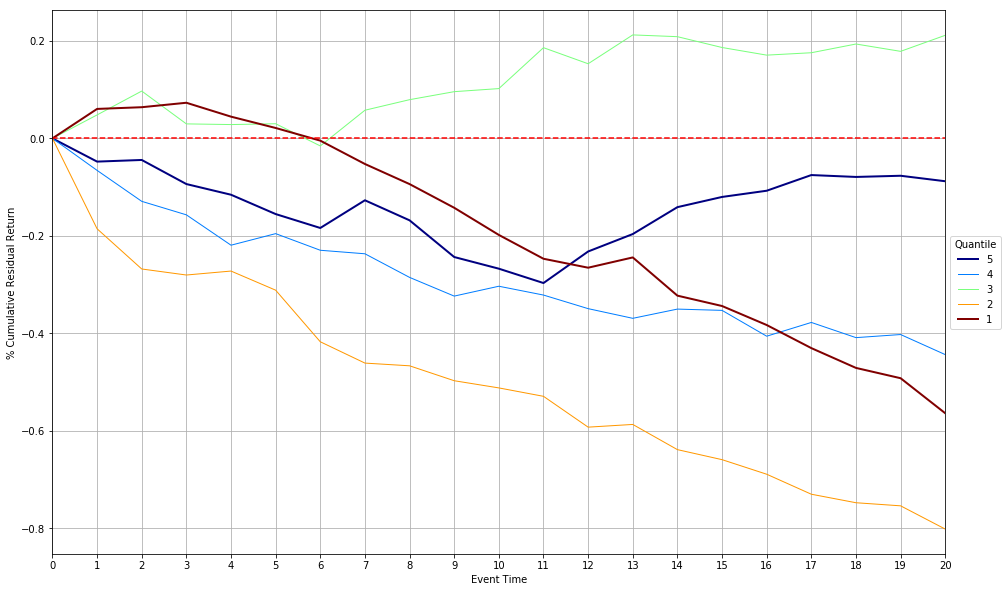

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,0.06%,0.06%,0.07%,0.04%,0.02%,-0.20%,-0.34%,-0.56%
2,-0.19%,-0.27%,-0.28%,-0.27%,-0.31%,-0.51%,-0.66%,-0.80%
3,0.05%,0.10%,0.03%,0.03%,0.03%,0.10%,0.19%,0.21%
4,-0.07%,-0.13%,-0.16%,-0.22%,-0.20%,-0.30%,-0.35%,-0.44%
5,-0.05%,-0.04%,-0.09%,-0.12%,-0.16%,-0.27%,-0.12%,-0.09%


### Mega Cap (All-Time)

Num Events: 277


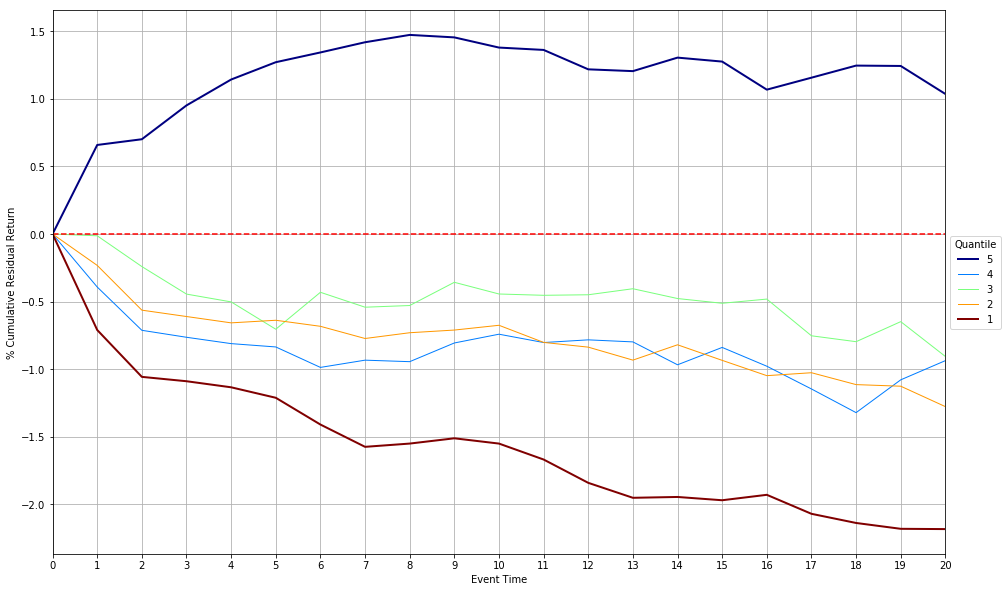

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.71%,-1.06%,-1.09%,-1.13%,-1.21%,-1.55%,-1.97%,-2.18%
2,-0.23%,-0.56%,-0.61%,-0.66%,-0.64%,-0.68%,-0.93%,-1.28%
3,-0.01%,-0.24%,-0.44%,-0.50%,-0.70%,-0.44%,-0.51%,-0.91%
4,-0.39%,-0.71%,-0.76%,-0.81%,-0.84%,-0.74%,-0.84%,-0.94%
5,0.66%,0.70%,0.95%,1.14%,1.27%,1.38%,1.28%,1.04%


In [21]:
market_cap_types = ['Micro', 'Small', 'Mid', 'Large', 'Mega']

for market_cap_type in market_cap_types:
    mdf = es_market_caps[0]
    mdf = filter(mdf, 'market_cap_type', market_cap_type)
    display_results((mdf, None), '{} Cap (All-Time)'.format(market_cap_type))
